# 09. Comparison of Model System Scales

## Numerical experiments - Week 04/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## Prerequisite libraries

In [1]:
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./plotting.jl")
Revise.includet("./setup.jl")
Revise.includet("./solver.jl")
using .Conversions
using .Diffusion
using .Plotting

## 1. Revision of scale assumptions - 3 options

### 1.1. Spore-scale simulation

The diffusion model developed so far is based on the discretisation of space using a single spore diameter as a spatial increment. This leads to a straightforward abstraction of the spore as a special node on the lattice which differs in its concentration contribution from the nodes of the extracellular medium. However, it could be argued that this discretisation is too arbitrary, too rough or leading to incoherences in the interpretation of the interface between spore and medium. For this reason, two additional alternative schemes are proposed.

### 1.2. Super-spore-scale simulation

First, inspired by the approach taken in the derivation of the analytical scheme in Notebook 7, it can be assumed that the spore source is of negligible size compared to the lattice resolution and that a single lattice site is a discrete box that _contains_ the spore, but their boundaries are not coincident. The spore can therefore be seen as a singular source which is not significantly large to pose an obstacle for diffusion within the box, but adds new concentration to the box with a rate based on the concentration difference between the spore and the medium. In this sense, the slow-permeating sub-system of the spore is spatially removed from the sub-system of the medium lattice, but they do communicate via the entry node assumed to contain the spore. The concentration drop between the spore and its containing cell evolves over time as follows:

$$
\begin{equation}
\frac{d{(c_{\textrm{in}}-c_{\textrm{out}})}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}})
\end{equation}
$$

This can be rewritten as

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}-\frac{d{c_{\textrm{out}}}}{dt}=-\frac{AP_s}{V}(c_{\textrm{in}}-c_{\textrm{out}}).
\end{equation}
$$

The derivative $\frac{d{c_{\textrm{out}}}}{dt}$ is approximated by a finite difference scheme:

$$
\begin{equation}
\frac{d{c_{\textrm{out}}}}{dt}\approx\frac{c_{\textrm{out}}(t+\delta{t})-c_{\textrm{out}}(t)}{\delta{t}}
\end{equation}
$$

Similarly,

$$
\begin{equation}
\frac{d{c_{\textrm{in}}}}{dt}\approx\frac{c_{\textrm{in}}(t+\delta{t})-c_{\textrm{in}}(t)}{\delta{t}}
\end{equation}
$$

Using these discretisations, the update of the spore concentration can be expressed as

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+c_{\textrm{in}}(t)-c_{\textrm{out}}(t)-\frac{AP_s}{V}\delta{t}(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))=c_{\textrm{out}}(t+\delta{t})+(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{V}\delta{t}\right).
\end{equation}
$$

The problem arising here is the interdependence between $c_{\textrm{in}}(t+\delta{t})$ and $c_{\textrm{out}}(t+\delta{t})$. This can be resolved by implementing a half-step for updating the concentration drop:

$$
\begin{equation}
\Delta{c}^{(1/2)}=(c_{\textrm{in}}(t)-c_{\textrm{out}}(t))\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

The outside concentration in the spore-containing volume is then updated as a mixture of free diffusion with neighbour cells of the medium and the added concentration from the source:

$$
\begin{equation}
c_{\textrm{out}}(t+\delta{t})=c_{\textrm{out}}(t)+\delta{t}\left[D\nabla^2c_{\textrm{out}}(t)+\frac{AP_s}{V}\Delta{c}^{(1/2)}\right].
\end{equation}
$$

Finally, the inside concentration at a full time step can be completed:

$$
\begin{equation}
c_{\textrm{in}}(t+\delta{t})=c_{\textrm{out}}(t+\delta{t})+\Delta{c}^{(1/2)}\left(1-\frac{AP_s}{2V}\delta{t}\right).
\end{equation}
$$

### 1.3. Cell-wall-scale simulation

A second option considers the opposite scenario --- a much more fine-grain lattice, such that the detail of the spore's spherical shape can be captured. This becomes important in observing the spatial articulation of spore packings caused by aggregation and furthermore improves the accuracy of the diffusion simulation by considering scales closer to the infinitessimal limit.

Since the high resolution of the lattice requires significantly increased computation, drastic optimisation measures are required. For this purpose, each cell in the lattice performs a dynamic check of its distance to the spore centre, given the spore radius. If the cell falls within this radius but has excluded neighbours (in its von Neumann neighbourhood), then it is considered a member of the cell wall - the source region governed by slow diffusion. If it is excluded from the radius along with all of its neighbours, it is a member of the medium region. If the cell and all of its neighbours are within the radius, it is excluded from the computation.

Since the other two methods compute the concentration relative to the entire spore volume, as opposed to just the cell wall volume, the resulting lattice concentrations from the high-resolution procedure are related to the entirety of the spore sphere. This is performed by first multiplying each concentration by $d{x}^3$, them summing the inhibitor quantities from all cell wall nodes and dividing them by the spore volume. To optimise storage, the simulation only records cross-sections through the middle of the lattice. To avoid the contributions of eccentrically cut neighbours, only the central spore is being calculated with, approximating its full cell wall volume from the cross-sectional one by using a factor of $2R/d$, where $R$ is the spore radius and $d$ is the cell wall thickness.

## 2. Comparative experiment

The two newly proposed options are constructed and tested against the original discretisation scheme, applying different resolutions on a lattice with the same spatial dimensions and simulating inhibitor diffusion with a single spore. The concentration at the spore is recorded and compared to the analytical solution and among the numerical schemes.

In [1]:
using PyPlot
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./plotting.jl")
Revise.includet("./setup.jl")
Revise.includet("./solver.jl")
using .Conversions
using .Diffusion
using .Plotting

In [5]:
# Global parameters
D = 600 # microns^2/s
Ps_fit = 0.0002675353069511818 # microns/s
t_max = 100#300#10.0#14400 # s
c0_spore = 1.5 # x10^(-5) M
c0_cw = 3.84 # x10^(-5) M
spore_diameter = 5 # microns
K = 1#316.23 # partition coefficient, set to 1 since we don't necessarily deal with lipid membranes

# ----- Analytical solution -----
c_out = 0.0 # M
times = LinRange(0, t_max, 1000)

# Cube spore
V_spore_cube = spore_diameter^3 # microns^3
A_spore_cube = 6 * spore_diameter^2 # microns^2
c_analytical_cube = permeation_time_dependent_analytical(c0_spore, c_out, times, Ps_fit, A_spore_cube, V_spore_cube)
println("Analytical solution for spore with V=$V_spore_cube and A=$A_spore_cube: ", c_analytical_cube[end])

# Sphere spore
V_spore_sphere = 4π * (spore_diameter / 2)^3 / 3 # microns^3
A_spore_sphere = 4π * (spore_diameter / 2)^2 # microns^2
c_analytical_sphere = permeation_time_dependent_analytical(c0_spore, c_out, times, Ps_fit, A_spore_sphere, V_spore_sphere)
println("Analytical solution for spore with V=$V_spore_sphere and A=$A_spore_sphere: ", c_analytical_sphere[end])

# ----- Numerical solution -----
n_save_frames = 100

# Mid resolution
N_mid = 64
dt = 0.005
spore_idx = (N_mid ÷ 2, N_mid ÷ 2, N_mid ÷ 2)
c_init = zeros(N_mid, N_mid, N_mid)
c_init[spore_idx...] = c0_spore
c_numerical_mr, times_numerical_mr, _ = diffusion_time_dependent_GPU(c_init, t_max; D, Ps=Ps_fit, dt=dt, dx=spore_diameter, n_save_frames=n_save_frames, spore_idx=spore_idx)
println("Numerical solution (mid-resolution): ", c_numerical_mr[end, spore_idx...])

# Low resolution
scale_factor = 4 # 1 cell is 4 spore diameters long
N_lo = N_mid ÷ scale_factor
dt = 0.1
dx = spore_diameter * scale_factor
spore_vol_idx = (N_lo ÷ 2, N_lo ÷ 2, N_lo ÷ 2)
c_init = zeros(N_lo, N_lo, N_lo)
_, c_numerical_lr, times_numerical_lr, _ = diffusion_time_dependent_GPU_low_res(c_init, c0_spore, t_max; D=D, Pₛ=Ps_fit, 
                                                                            A=A_spore_sphere, V=V_spore_sphere, dt=dt, dx=dx,
                                                                            n_save_frames=n_save_frames, spore_vol_idx=spore_vol_idx)
println("Numerical solution (low-resolution): ", c_numerical_lr[end])

# High resolution (implicit)
space_scale = 1.0#000.0
time_scale = 1.0
N_hi = 256#800 # 1 cell is 0.20 um long
dt = 0.001##75#0.00001 * time_scale #0.00001
dx = 0.2 * space_scale # cell wall thickness
Db = Ps_fit * dx * space_scale / K # compute diffusion coefficient from permeability
spore_center_idx = (N_hi ÷ 2, N_hi ÷ 2, N_hi ÷ 2)
c_init = zeros(Float64, N_hi, N_hi, N_hi)
# Pay attention to re-scaled parameters!
c_frames_hr, c_numerical_hr, times_numerical_hr, region_ids, _ = diffusion_time_dependent_GPU_hi_res_implicit(c_init, c0_cw, [spore_center_idx], space_scale*spore_diameter / 2, t_max*time_scale;
                                                                        D=D*space_scale^2/time_scale, Db=Db/time_scale, dt=dt, dx=dx, n_save_frames=n_save_frames, crank_nicolson=false)
println("Numerical solution (high-resolution): ", c_numerical_hr[end])

Analytical solution for spore with V=125 and A=150: 1.4526084499209286
Analytical solution for spore with V=65.44984694978736 and A=78.53981633974483: 1.4526084499209286
3D simulation
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Storage arrays allocated.
Numerical solution (mid-resolution): 1.4523162841796875
3D simulation
Using D = 600, Ps = 0.0002675353069511818
Storage arrays allocated.
Numerical solution (low-resolution): 1.4526937007904053
Using D = 600.0, Db = 5.350706139023637e-5, Dcw = 2.6753531888037245e-5
D*dt/dx2 = 14.999999999999996, Db*dt/dx2 = 1.3376765347559088e-6, Dcw*dt/dx2 = 6.68838297200931e-7
Timescale for accuracy: 6.666666666666668e-5
Spore radius in lattice units: 12.5
Storage arrays allocated.
Frame 1 saved.
Frame 2 saved.
Frame 3 saved.
Frame 4 saved.
Frame 5 saved.
Frame 6 saved.
Frame 7 saved.
Frame 8 saved.
Frame 9 saved.
Frame 10 saved.
Frame 11 saved.
Frame 12 saved.
Frame 13 saved.
Frame 14 saved.
Frame 15 saved.
Frame 16 saved.
F

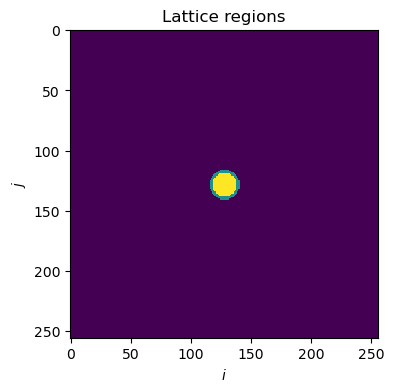

In [8]:
plot_lattice_regions(region_ids)

Plotting frames: [1, 2, 67, 101]


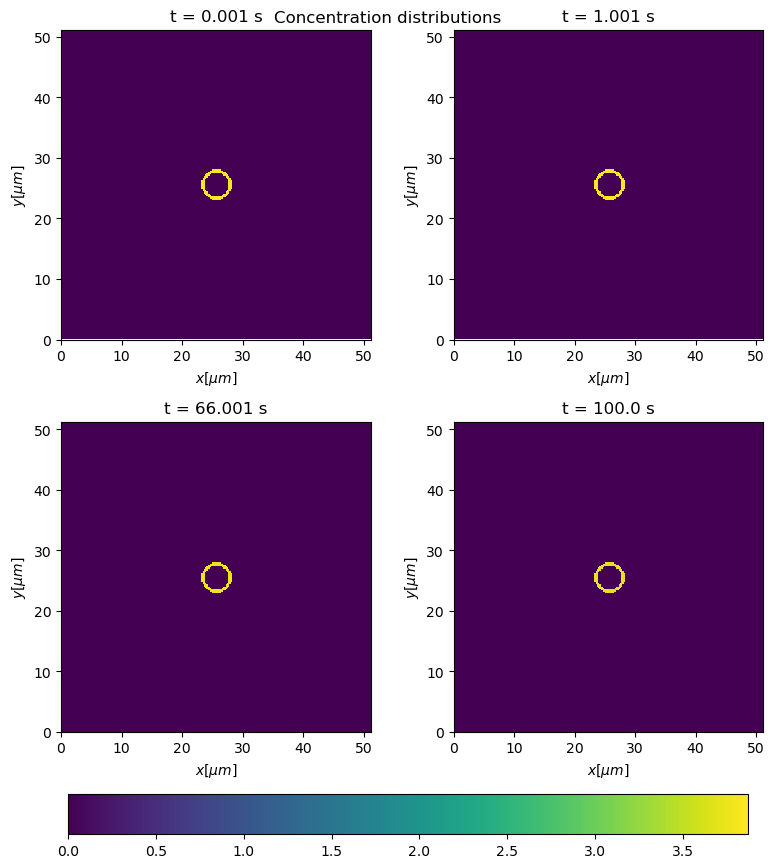

In [9]:
plot_concentration_lattice(c_frames_hr, dx,
                            frame_indices=[1, 2, round(Int, size(c_frames_hr)[1]*0.666), size(c_frames_hr)[1]],
                            times=times_numerical_hr, title="Concentration distributions")

Fitted exponential: (1.5001216960457289, -0.00032094623894870735)
Fitted exponential: (1.5001308049559943, -0.0003230439210800319)
Fitted exponential: (1.5101612643610371, -0.000317157790403096)


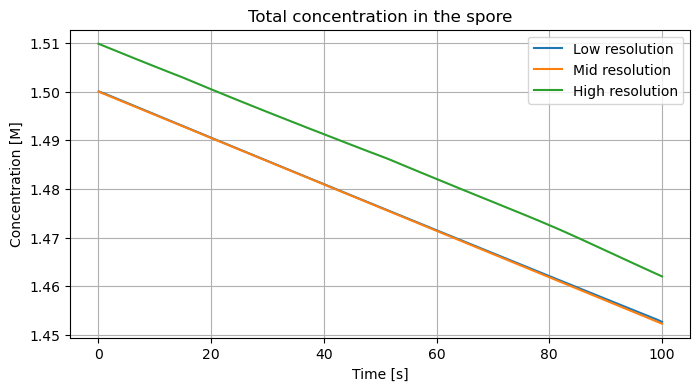

In [23]:
compare_concentration_evolutions([c_numerical_lr, c_numerical_mr[:, spore_idx...], c_numerical_hr[:]],
                                    [times_numerical_lr, times_numerical_mr, times_numerical_hr],
                                    ["Low resolution", "Mid resolution", "High resolution"], fit_exp=true)

The resulting plots indicate relatively good alignment, with some discretisation error reflected in an overestimation of the spore concentration in the high-resolution scheme. Nonetheless, all three scales exhibit the same decay exponent (approx. -0.00032), which verifies that they can accurately represent the same system with different levels of granularity.

The plot below shows the measured oscillations in the solutions from the Crank-Nelson implicit method at low time steps.

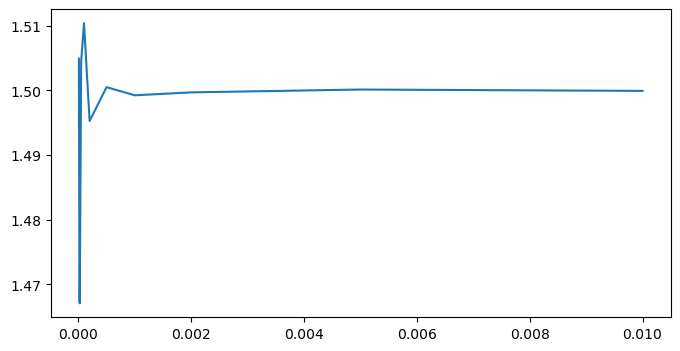

In [38]:
fig, ax = subplots(1, 1, figsize=(8, 4))
ax.plot([0.00001, 0.00002, 0.000025, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01],
    [1.5048929224400762, 1.4675215172683493, 1.467079706082919, 1.504441259753694, 1.5103601182596633, 1.4952611300259646, 1.5004846588950445, 1.4992288034937455, 1.4996793205407004, 1.5001188115480535, 1.499909844061341])
gcf()

## 3. Sparse matrix exercise

In [ ]:
using SparseArrays
using IterTools

In [ ]:
N = 20
rad = 5
spore_idx = (N ÷ 2, N ÷ 2)
medium_is, medium_js, medium_cs = [], [], []
cw_is, cw_js, cw_concs = [], [], []
for i in 1:N
    for j in 1:N
        steps = [-1, 0, 1]
        von_neumann_nbrs = collect(IterTools.product(steps, steps))
        excluded = false
        excluded_nbrs = 0
        for (di, dj) in von_neumann_nbrs
            if (i + di - spore_idx[1])^2 + (j + dj - spore_idx[2])^2 > rad^2
                if (di, dj) == (0, 0)
                    excluded = true
                    push!(medium_is, i)
                    push!(medium_js, j)
                    push!(medium_cs, 1.0)
                else
                    excluded_nbrs += 1
                end
            end
        end
        if !excluded && excluded_nbrs > 0
            push!(cw_is, i)
            push!(cw_js, j)
            push!(cw_concs, 1.0)
        end
    end
end
# nz_is = hcat(nz_is...)
# nx_js = hcat(nx_js...)
# nz_concs = hcat(nz_concs...)
medium_sparse = sparse(medium_is, medium_js, medium_cs, N, N)
cw_sparse = sparse(cw_is, cw_js, cw_concs, N, N)

20×20 SparseMatrixCSC{Any, Int64} with 36 stored entries:
⎡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⢠⠖⠚⠒⢦⠀⠀⠀⎥
⎢⠀⠀⢺⠀⠀⠀⢸⠂⠀⠀⎥
⎢⠀⠀⠈⠓⠲⠒⠋⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦